# ANAC

# data read-in

In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew, kurtosis, probplot

In [121]:
seed = 2024
np.random.seed(seed)

In [122]:
diet_csv = pd.read_csv("diet.csv").copy()
recipes_csv = pd.read_csv("recipes.csv").copy()
requests_csv = pd.read_csv("requests.csv").copy()
reviews_csv = pd.read_csv("reviews.csv").copy()

/var/folders/z0/24mzs0z565s6qpzztgbdrj780000gn/T/ipykernel_50058/3884275055.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_csv = pd.read_csv("reviews.csv").copy()


# Basics

In [123]:
diet_csv.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)
reviews_csv.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)

diet_csv["Diet"] = diet_csv["Diet"].astype("category")

recipes_csv["RecipeCategory"] = recipes_csv["RecipeCategory"].astype("category")

requests_csv.rename(columns= {
    "AuthorId" : "CustomerId",
    "Time": "MaxTime"
}, inplace=True)

# Handing missing values

In [124]:
diet_csv['Diet'].fillna('Vegetarian', inplace=True)


# with mean
recipesServings_mean = recipes_csv['RecipeServings'].mean()
#fill na rows with the mean
recipes_csv['RecipeServings'].fillna(recipesServings_mean, inplace=True)
recipesServings_mean = recipes_csv['RecipeServings'].mean()



mapping_cal = {1: 1, 0.0: 0}
requests_csv['HighCalories'] = requests_csv['HighCalories'].map(mapping_cal).astype('category')

mapping_protein = {'Yes': 1, 'Indifferent': 0, 'No': 0, }
requests_csv['HighProtein'] = requests_csv['HighProtein'].map(mapping_protein).astype('category')

requests_csv['LowFat'] = requests_csv['LowFat'].astype('category')

mapping_sugar = {'1': 1, 'Indifferent': 0, '0': 0, }
requests_csv['LowSugar'] = requests_csv['LowSugar'].map(mapping_sugar).astype('category')

requests_csv['HighFiber'] = requests_csv['HighFiber'].astype('category')

# Merge tables


In [125]:
#merge diet + review
reviews_csv["Like"] = reviews_csv["Like"].astype("category")
reviews_csv = reviews_csv.drop("Rating", axis=1)
reviews_csv.dropna(subset=["Like"], inplace=True) # note: now the entries are reduced to 97381 entries
reviews_csv = reviews_csv.drop("TestSetId", axis=1)
review_with_diet = pd.merge(reviews_csv, diet_csv, on="CustomerId", how="inner") # 97381 entries
#merge diet + review + request
review_diet_with_request = pd.merge(review_with_diet, requests_csv, on=["CustomerId", "RecipeId"], how="inner") # 97381 entries
df = pd.merge(review_diet_with_request, recipes_csv, on='RecipeId', how='left')
df = pd.get_dummies(df, columns=['Diet', 'RecipeCategory'], drop_first=True) 

df

,CustomerId,RecipeId,Like,Age,MaxTime,HighCalories,HighProtein,LowFat,LowSugar,HighFiber,...,RecipeServings,RecipeYield,Diet_Vegan,Diet_Vegetarian,RecipeCategory_Bread,RecipeCategory_Breakfast,RecipeCategory_Lunch,RecipeCategory_One dish meal,RecipeCategory_Other,RecipeCategory_Soup
0,1000036C,320576,False,50,119.024930,0,0,0,0,1,...,1.000000,NaN,False,True,False,False,False,False,False,False
1,1000216B,189335,False,78,1199.386790,0,1,0,0,1,...,8.000000,NaN,False,True,False,False,False,False,True,False
2,1000221A,133043,False,25,362.152341,0,1,0,0,1,...,8.828455,4 ounces,False,True,False,False,False,False,True,False
3,1000221A,90537,False,25,1198.957497,0,1,0,0,1,...,1.000000,NaN,False,True,False,True,False,False,False,False
4,1000221A,334314,False,25,5400.036634,1,0,0,0,0,...,8.828455,1 large loaf,False,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97376,999595E,338070,False,31,3899.421310,0,0,1,0,0,...,16.000000,NaN,False,True,False,False,False,False,True,False
97377,999774A,29002,False,57,2402.372535,0,0,0,0,0,...,4.000000,NaN,False,True,False,False,False,False,True,False
97378,999774A,159252,False,57,5999.598903,0,1,0,0,0,...,8.828455,4 cups,False,True,False,False,False,False,True,False
97379,999774A,1171,True,57,480.233207,1,1,0,0,0,...,1.000000,2 mugs,False,True,False,False,False,False,False,False


# Plot continuous variables vs Like

## Handling outliers

In [126]:

maxtime_val = df['MaxTime'].max()
outliers = df['MaxTime'] >= maxtime_val
median_without_outliers = df.loc[~outliers, 'MaxTime'].median()
df.loc[outliers, 'MaxTime'] = median_without_outliers

maxtime_val = df['PrepTime'].max()
outliers = df['PrepTime'] >= maxtime_val
median_without_outliers = df.loc[~outliers, 'PrepTime'].median()
df.loc[outliers, 'PrepTime'] = median_without_outliers
outliers = (df['Like'] == True) & (df['PrepTime'] > 3000000)
df.loc[outliers, 'PrepTime'] = median_without_outliers

outliers = (df['Like'] == True) & (df['Calories'] > 30000)
median_without_outliers = df.loc[~outliers, 'Calories'].median()
df.loc[outliers, 'Calories'] = median_without_outliers

outliers = df['FatContent'] > 25000
median_without_outliers = df.loc[~outliers, 'FatContent'].median()
df.loc[outliers, 'FatContent'] = median_without_outliers
outliers = (df['Like'] == True) & (df['FatContent'] > 2500)
df.loc[outliers, 'FatContent'] = median_without_outliers

outliers = df['SaturatedFatContent'] > 12000
median_without_outliers = df.loc[~outliers, 'SaturatedFatContent'].median()
df.loc[outliers, 'SaturatedFatContent'] = median_without_outliers

outliers = df['CholesterolContent'] > 35000
median_without_outliers = df.loc[~outliers, 'CholesterolContent'].median()
df.loc[outliers, 'CholesterolContent'] = median_without_outliers
outliers = (df['Like'] == True) & (df['CholesterolContent'] > 10000)
df.loc[outliers, 'CholesterolContent'] = median_without_outliers

outliers = (df['Like'] == True) & (df['CarbohydrateContent'] > 4000)
median_without_outliers = df.loc[~outliers, 'CarbohydrateContent'].median()
df.loc[outliers, 'CarbohydrateContent'] = median_without_outliers

outliers = (df['Like'] == True) & (df['FiberContent'] > 400)
median_without_outliers = df.loc[~outliers, 'FiberContent'].median()
df.loc[outliers, 'FiberContent'] = median_without_outliers

outliers = (df['Like'] == True) & (df['SugarContent'] > 4000)
median_without_outliers = df.loc[~outliers, 'SugarContent'].median()
df.loc[outliers, 'SugarContent'] = median_without_outliers

outliers = df['ProteinContent'] > 17500
median_without_outliers = df.loc[~outliers, 'ProteinContent'].median()
df.loc[outliers, 'ProteinContent'] = median_without_outliers
outliers = (df['Like'] == True) & (df['ProteinContent'] > 3000)
df.loc[outliers, 'ProteinContent'] = median_without_outliers

outliers = df['RecipeServings'] > 30000
median_without_outliers = df.loc[~outliers, 'RecipeServings'].median()
df.loc[outliers, 'RecipeServings'] = median_without_outliers
outliers = (df['Like'] == True) & (df['RecipeServings'] > 400)
df.loc[outliers, 'RecipeServings'] = median_without_outliers


# Data standardization and dimensional reduction

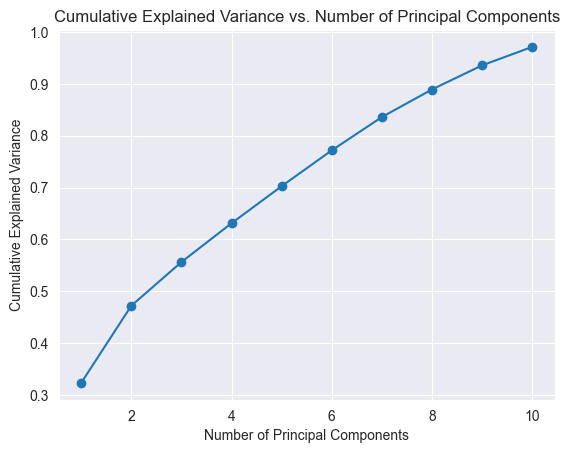

In [132]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()

columns_to_standardized= ['Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'MaxTime', 'PrepTime', 'CookTime', 'Age', 'RecipeServings']
df[columns_to_standardized] = scaler.fit_transform(df[columns_to_standardized])


transform_pca = PCA(n_components=10)
principal_components = transform_pca.fit_transform(df[columns_to_standardized])


explained_variance_ratio = transform_pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.show()

# Fit Model

In [128]:
X = df.drop(['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield', 'RecipeCategory_Other', ], axis=1)
y = df['Like']

In [129]:
# split data into learning and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=3)
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=31, min_samples_leaf=5, random_state=2024)
model.fit(X_train, y_train)
min_samples_split_value = model.min_samples_split
print("min_samples_split:", min_samples_split_value)

from sklearn.metrics import balanced_accuracy_score, accuracy_score

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_accuracy)

from sklearn.ensemble import BaggingClassifier

bagging_classifier = BaggingClassifier(model, n_estimators=100, random_state=2024)
bagging_classifier.fit(X_train, y_train)
predictions_bagging = bagging_classifier.predict(X_test)
accuracy_bagging = accuracy_score(y_test, predictions_bagging)
balanced_accuracy_bagging = balanced_accuracy_score(y_test, predictions_bagging)
print("Accuracy with bagging:", accuracy_bagging)
print("Balanced Accuracy with bagging:", balanced_accuracy_bagging)

min_samples_split: 2
Accuracy: 0.8676364881054253
Balanced Accuracy: 0.6874032348823822
Accuracy with bagging: 0.8965599863084032
Balanced Accuracy with bagging: 0.6914468121919988


In [130]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

train_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.6,random_state=seed)


train_model.fit(X,y)

score = np.mean(cross_val_score(train_model, X, y, cv=5, scoring="balanced_accuracy"))
print("Cross validation score for balanced accuracy: " + str(score))

Cross validation score for balanced accuracy: 0.697142808162654
